In [10]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import json
import plotly.express as px
import pandas as pd
from collections import Counter

from embed_articles import embed_articles
from cosine_similarity import cosine_sim
from get_data import get_new_articles

In [11]:
data_filename = 'newsdata.json'
embeddings_filename = 'embedded_articles.pkl'
cossim_desc_filename = 'cosine_similiarties_descriptions.pkl'
cossim_title_filename = 'cosine_similiarties_titles.pkl'
embedding_variables = ['description', 'title']
run_embedding = False   # True if no local file with embeddings
run_cossim = False      # True if no local file with cosine similiarities
save_results = False    # If True, then the embeddings and cossims are saved to a file after they are run
run_new_pos = True      # True if no local file with newest positions

get_new_nodes = False # Set to true if you want to use api credits to get more data

create_new_graph = True # True if you want to create a new graph with your embeddings. False to load in existing from .gml file
save_new_graph = True # True to save your new graph

In [12]:
# Run to use up to 30 newsdata.io credits for more articles
if get_new_nodes:
    william, bella, nicolai = 'pub_d9de26b5f5c540558489f00542c6366d', 'pub_b17b6c07e5924b47a7266d5a23f43a33', 'pub_2ffc1a6468d240ee80c80400eeea1c23'
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles before: {len(json.load(f))-1}')
    try:
        get_new_articles(api_key=nicolai, data_filename=data_filename, verbose=False)
    except Exception as e:
        print('No more api credits')
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles after: {len(json.load(f))-1}')

In [13]:
if run_embedding:
    # Embedding all articles
    print('Running embedding')
    embedded_articles, embedding_length, num_articles = embed_articles(input_filename=data_filename, 
                                                                    embedding_variables=embedding_variables) 
    print("Size of each embedding:", embedding_length)
    print("Amount of articles reviewed:", num_articles)
    print("Amount of articles embedded:", len(embedded_articles))
    print("Finished running embedding")
    
    if save_results:
        print("Saving embeddings to file")
        with open(embeddings_filename, 'wb') as f:
            pickle.dump(embedded_articles, f)
else:
    with open(embeddings_filename, 'rb') as f:
        embedded_articles = pickle.load(f)

if run_cossim:
    # Calculating cosine similarity on titles and descriptions
    print()
    print("Running cosine similarity")
    emb_titles = []
    emb_desc = []
    for key in embedded_articles.keys():
        emb_titles.append(embedded_articles[key]['embedded_title'])
        emb_desc.append(embedded_articles[key]['embedded_description'])
    print("Running cosine similarities for titles")
    cossim_titles = cosine_sim(input_data=emb_titles)
    print("Running cosine similarities for descriptions")
    cossim_desc = cosine_sim(input_data=emb_desc)
        
    print("Finished running cosine similarity")
    
    if save_results:
        print("Saving cossims to file")
        with open(cossim_title_filename, 'wb') as f:
            pickle.dump(cossim_titles, f)
        with open(cossim_desc_filename, 'wb') as f:
            pickle.dump(cossim_desc, f)
else:
    with open(cossim_desc_filename, 'rb') as f:
        cossim_desc = pickle.load(f)
    with open(cossim_title_filename, 'rb') as f:
        cossim_titles = pickle.load(f)
        
# Getting articles without embeddings for creating attributes for nx graph
print('Extracting articles without embeddings')
all_articles = {}
for id, article in embedded_articles.items():
    article_no_embedding = article
    for var in embedding_variables:
        article_no_embedding.pop(f'embedded_{var}')
    all_articles[id] = article_no_embedding

Extracting articles without embeddings


In [14]:
num_rows = len(all_articles.keys())
num_variables = len(all_articles['2c5f9d3455e1dc5ca96c14d39bd2d61d'].keys())

print(f"Number of rows: {num_rows}\nNumber of variables: {num_variables}")

Number of rows: 5401
Number of variables: 8


In [15]:
thres = 0.35
if create_new_graph:
    G = nx.Graph()
    G.add_nodes_from(list(all_articles.keys()))

    for i in tqdm(range(len(cossim_desc)-1)):
        id_i = list(all_articles.keys())[i]
        for j in range(i+1, len(cossim_desc)):
            id_j = list(all_articles.keys())[j]
            if cossim_desc[i][j] >= thres:
                G.add_edge(id_i, id_j)

    nx.set_node_attributes(G, all_articles)
    
    if save_new_graph:
        nx.write_gml(G, f'nx_graph_{thres}.gml')
else:
    G = nx.read_gml(f'nx_graph_{thres}.gml')

100%|██████████| 5400/5400 [12:28<00:00,  7.22it/s] 


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

## Adding press freedom index data

pressfreedom = pd.read_csv('RWB_PFI_WIDEF.csv')

names = [['Viet Nam', 'Vietnam'], ['Venezuela, RB', 'Venezuela'], ['Russian Federation', 'Russia'], 
         ['Kyrgyz Republic', 'Kyrgyzstan'], ['Hong Kong SAR, China', 'Hong Kong'], 
         ['United States', 'United States of America'], ['Syrian Arab Republic', 'Syria'], 
         ['Iran, Islamic Rep.', 'Iran'], ['Netherlands', 'Netherland'], ['Korea, Rep.', 'South Korea']]

labels = {'sociocultural context': 'sociocultural context score',
 'safety': 'safety score',
 'legal framework': 'legal framework score',
 'political context': 'political context score',
 'economic context': 'economic context'}

non_informative_att = []
for attribute in pressfreedom.keys():
    if len(pressfreedom[attribute].unique()) < 2:
        non_informative_att.append(attribute)
pressfreedom = pressfreedom.drop(columns=non_informative_att, axis=1)
pressfreedom = pressfreedom.drop(columns=['REF_AREA', 'UNIT_TYPE', 'INDICATOR', 'UNIT_MEASURE', 'UNIT_TYPE_LABEL', 'UNIT_MEASURE_LABEL'], axis=1)
pressfreedom['REF_AREA_LABEL'] = (pressfreedom['REF_AREA_LABEL'].replace(dict(names)))
pressfreedom['REF_AREA_LABEL'] = pressfreedom['REF_AREA_LABEL'].str.lower()
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.lower()
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.removeprefix('press freedom index: ')
pressfreedom['INDICATOR_LABEL'] = (pressfreedom['INDICATOR_LABEL'].replace(labels))

countries = []
for article in G.nodes.keys():
    if G.nodes[article]['country'] not in countries:
        countries.append(G.nodes[article]['country'][0])
countries = set(countries)
countries.remove('world')
countries.remove('solomon islands')

x = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
indicators = list(pressfreedom['INDICATOR_LABEL'].unique())
indicators.remove('press freedom index rank')

country_data = {}
for country in countries:
    if country in pressfreedom['REF_AREA_LABEL'].values:
        mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
        (pressfreedom['INDICATOR_LABEL'] == 'press freedom index rank'))
        out = pressfreedom.loc[mask, '2002':'2025'].values[0]
        mean, minrank, maxrank, median, variance, slope = round(np.mean(out),2), np.min(out), np.max(out), np.median(out), round(np.var(out),2), stats.linregress(x,list(out))[0]
        country_data[country] = {'press freedom index rank': {'current rank': out[-1], 
                                                            'slope of ranks': slope, 'mean rank': mean, 
                                                            'median rank': median, 'variance': variance, 
                                                            'min rank': minrank, 'max rank': maxrank}}
        for indicator in indicators:
            mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
            (pressfreedom['INDICATOR_LABEL'] == indicator))
            out = pressfreedom.loc[mask, '2025'].values[0]
            country_data[country][indicator] = out  

# Adding corruption perception index data

corruption = pd.read_csv('ti-corruption-perception-index.csv')
corruption['Entity'] = corruption['Entity'].str.lower()
corruption['World regions according to OWID'] = corruption['World regions according to OWID'].str.lower()

names = [['united states', 'united states of america'], ['netherlands', 'netherland']]
corruption['Entity'] = (corruption['Entity'].replace(dict(names)))

years = list(corruption['Year'].unique())

conts_dict = {cont: [] for cont in corruption['World regions according to OWID'].unique()[1:]}
for cont in corruption['World regions according to OWID'].unique()[1:]:
        mask = ((corruption['World regions according to OWID'] == cont))
        out = corruption.loc[mask, 'Entity'].values
        conts_dict[cont] = out

network_countries = []
for article in G.nodes.keys():
    if G.nodes[article]['country'] not in network_countries:
        network_countries.append(G.nodes[article]['country'][0])
network_countries = set(network_countries)
countries = []
for country in list(corruption['Entity'].unique()):
    if country in network_countries:
        countries.append(country)
countries = set(countries)


corruption_dict = {country: {} for country in countries}
for country in countries:
    if country in corruption['Entity'].values:
        years = corruption.loc[((corruption['Entity'] == country)), 'Year'].values  
        x = []
        y = []  
        for year in years:
            mask = ((corruption['Entity'] == country) &
                    (corruption['Year'] == year))
            if np.isnan(corruption.loc[mask, 'Corruption Perceptions Index'].values[0]):
                print(f"{country} has nan-value in {year}. Did not include")
            else:
                x.append(year)
                y.append(corruption.loc[mask, 'Corruption Perceptions Index'].values[0])
        if len(y) > 0:
            mean, minrank, maxrank, median, variance = round(np.mean(y),2), np.min(y), np.max(y), np.median(y), round(np.var(y),2)
            if len(y) >= 2:
                slope = stats.linregress(x, y).slope
            else:
                slope = 0
            corruption_dict[country] = {'latest score': y[-1], 'score slope': slope, 'mean score': mean, 'median score': median, 'score variance': variance, 'min score': minrank, 'max score': maxrank}
    for cont in conts_dict:
        if country in conts_dict[cont]:
            corruption_dict[country]['continent'] = cont

# Adding both as attributes in the network

for article in G.nodes().keys():
    data_given = False
    node_geo = G.nodes()[article]['country'][0]
    if node_geo in list(country_data.keys()):
        press_data = country_data[node_geo]
        data_given = True
    if node_geo in list(corruption_dict.keys()):
        corrup_data = corruption_dict[node_geo]
        data_given = True
    if data_given == True:
        G.nodes()[article]['country'] = {node_geo: {'press freedom index': press_data, 'corruption perception index': corrup_data}}

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
H = G.subgraph(max(nx.connected_components(G), key=len))
print("Number of nodes in largest connected component:", H.number_of_nodes())
print("Number of edges in largest connected component:", H.number_of_edges())
print("Node attributes are:", list(list(H.nodes(data=True))[0][1].keys()))
print(f"{round(len(H.nodes())/len(G.nodes())*100,2)}% of the nodes are in the largest connected component.")

Number of nodes in largest connected component: 5211
Number of edges in largest connected component: 71167
Node attributes are: ['link', 'title', 'description', 'country', 'category', 'pubDate', 'source_id', 'source_name']
96.48% of the nodes are in the largest connected component.


In [ ]:
if run_new_pos:
    pos = nx.forceatlas2_layout(G, max_iter=1000, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    pos2 = nx.forceatlas2_layout(H, max_iter=1000, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    with open(f'POS_{thres}.pkl', 'wb') as f:    # Saving POS as for later use, as they take time to compute
        pickle.dump(pos, f)
    with open(f'POS2_{thres}.pkl', 'wb') as f:
        pickle.dump(pos2, f)
else:
    with open(f'POS_{thres}.pkl', 'rb') as f:    # Loading previously computed POS
        pos = pickle.load(f)
    with open(f'POS2_{thres}.pkl', 'rb') as f:
        pos2 = pickle.load(f)

c:\Users\willi\anaconda3\envs\SGI\Lib\site-packages\networkx\drawing\layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


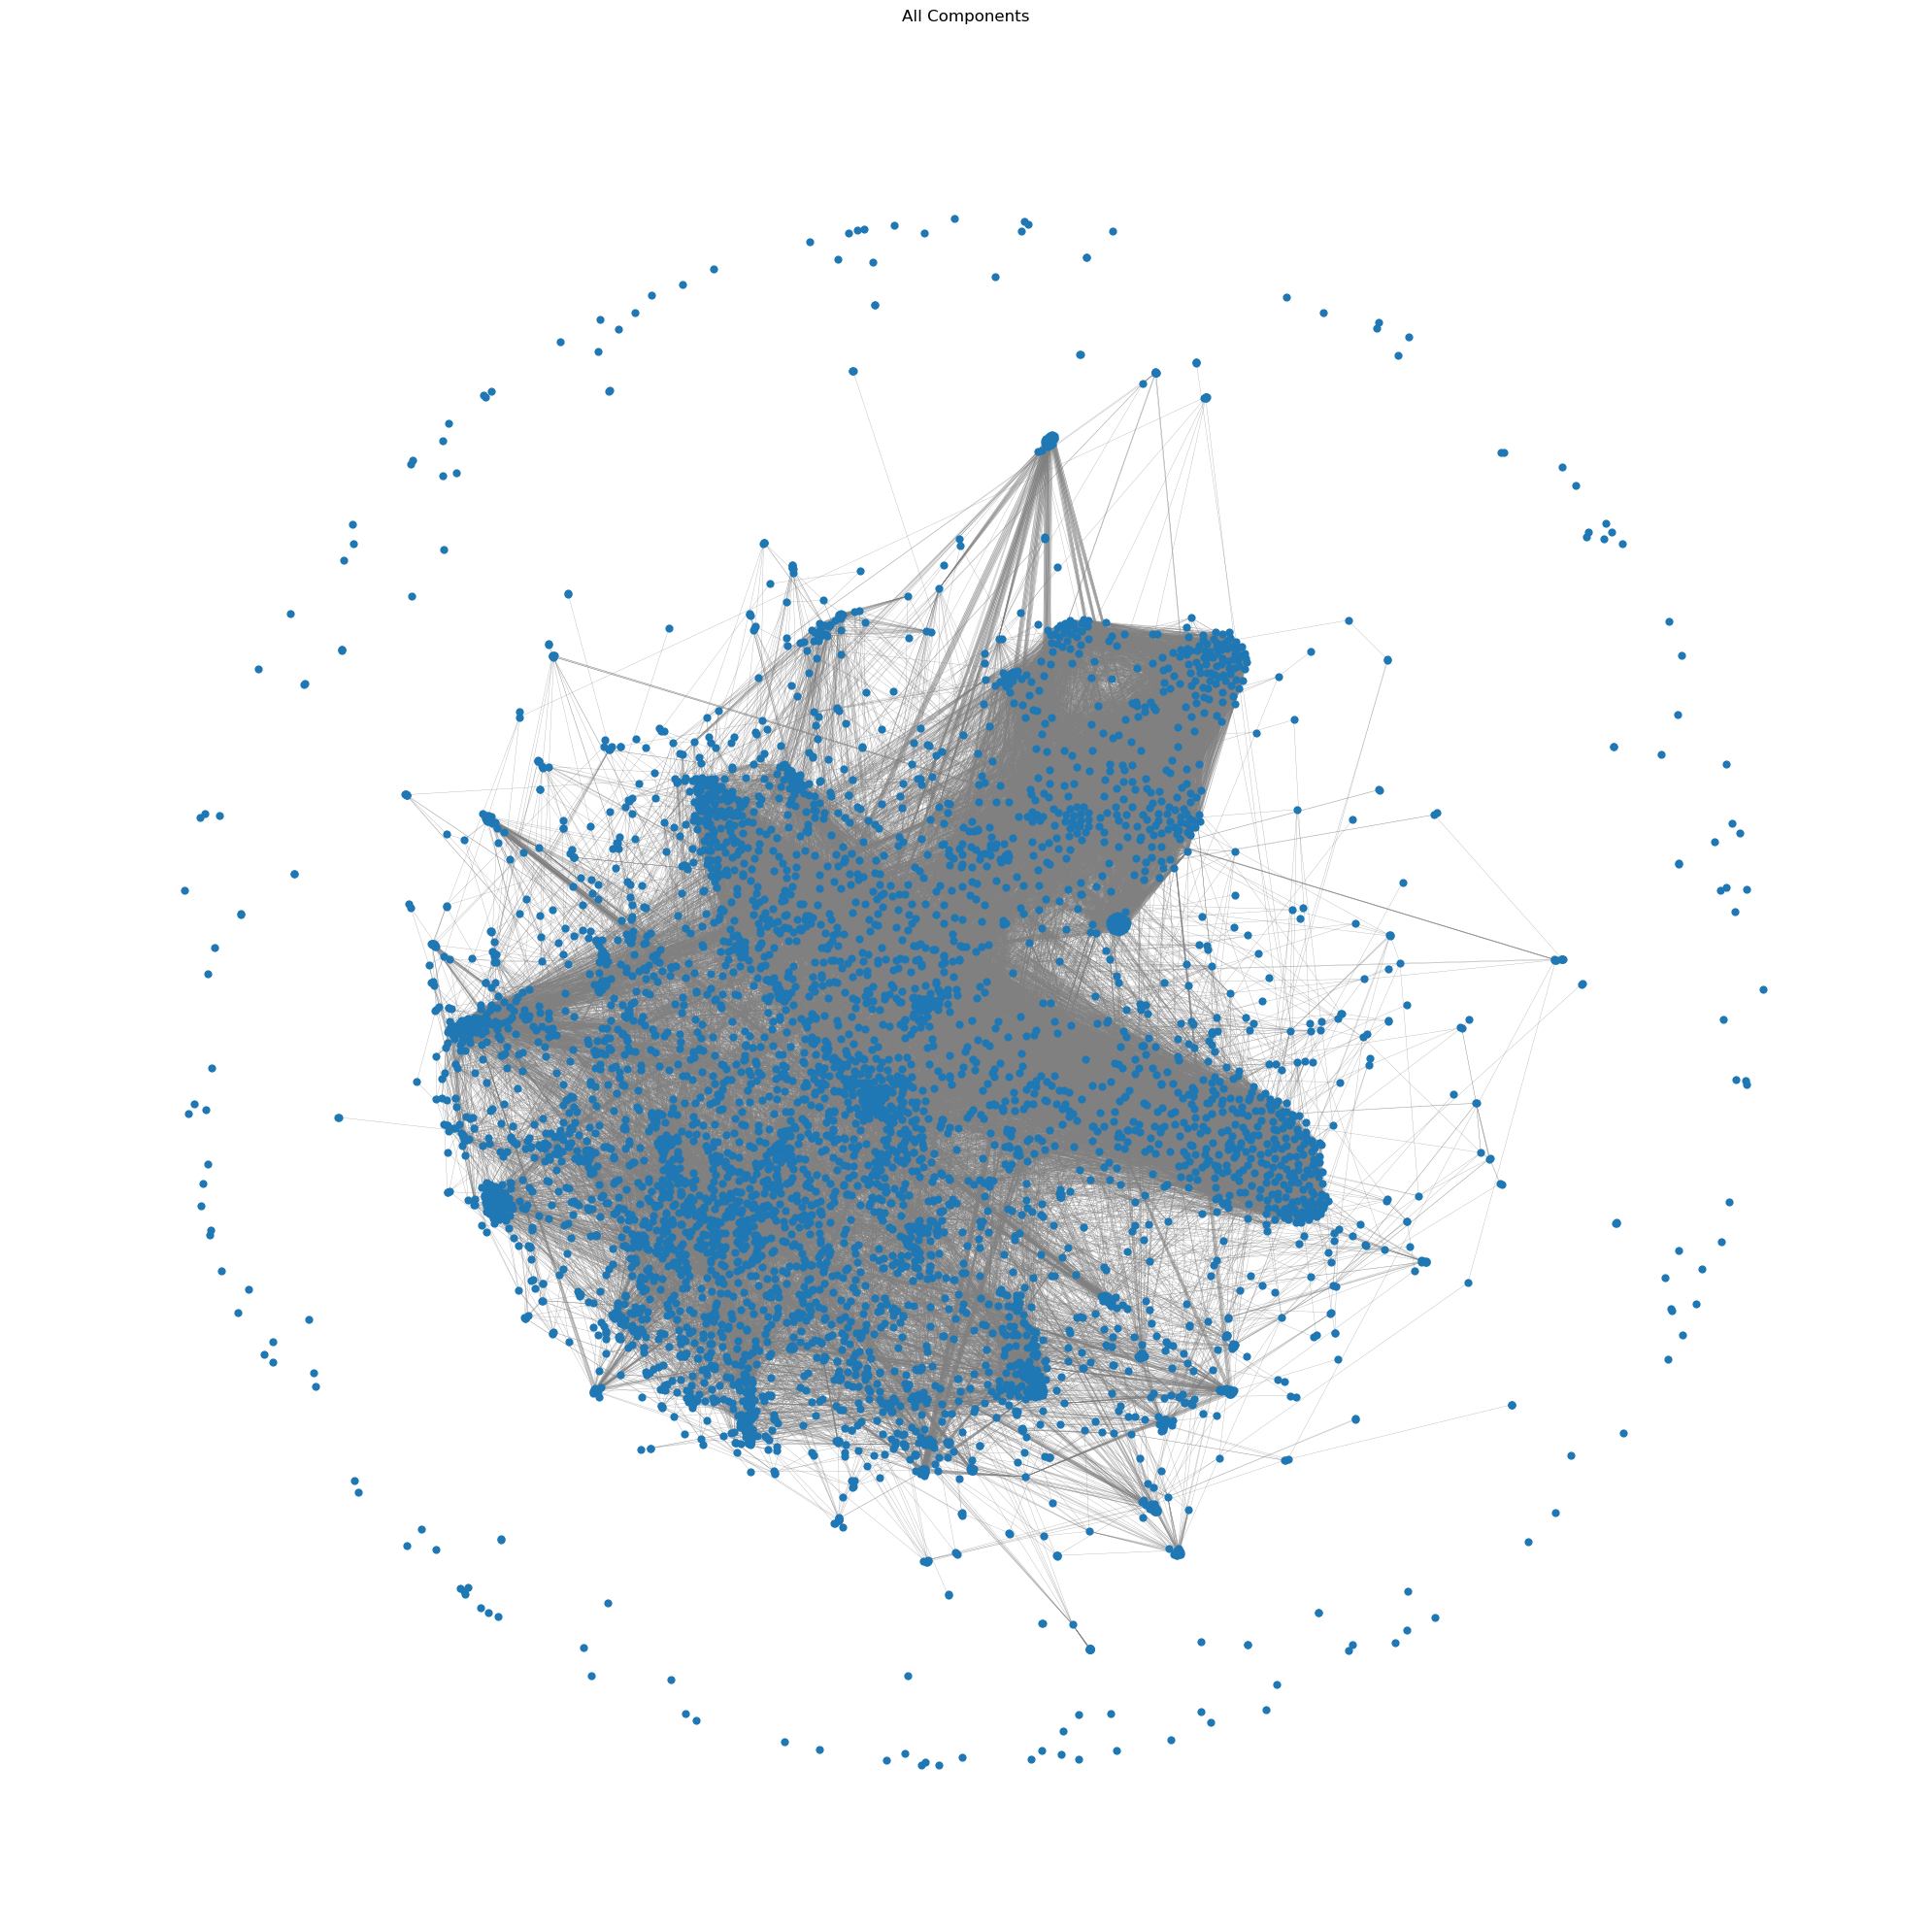

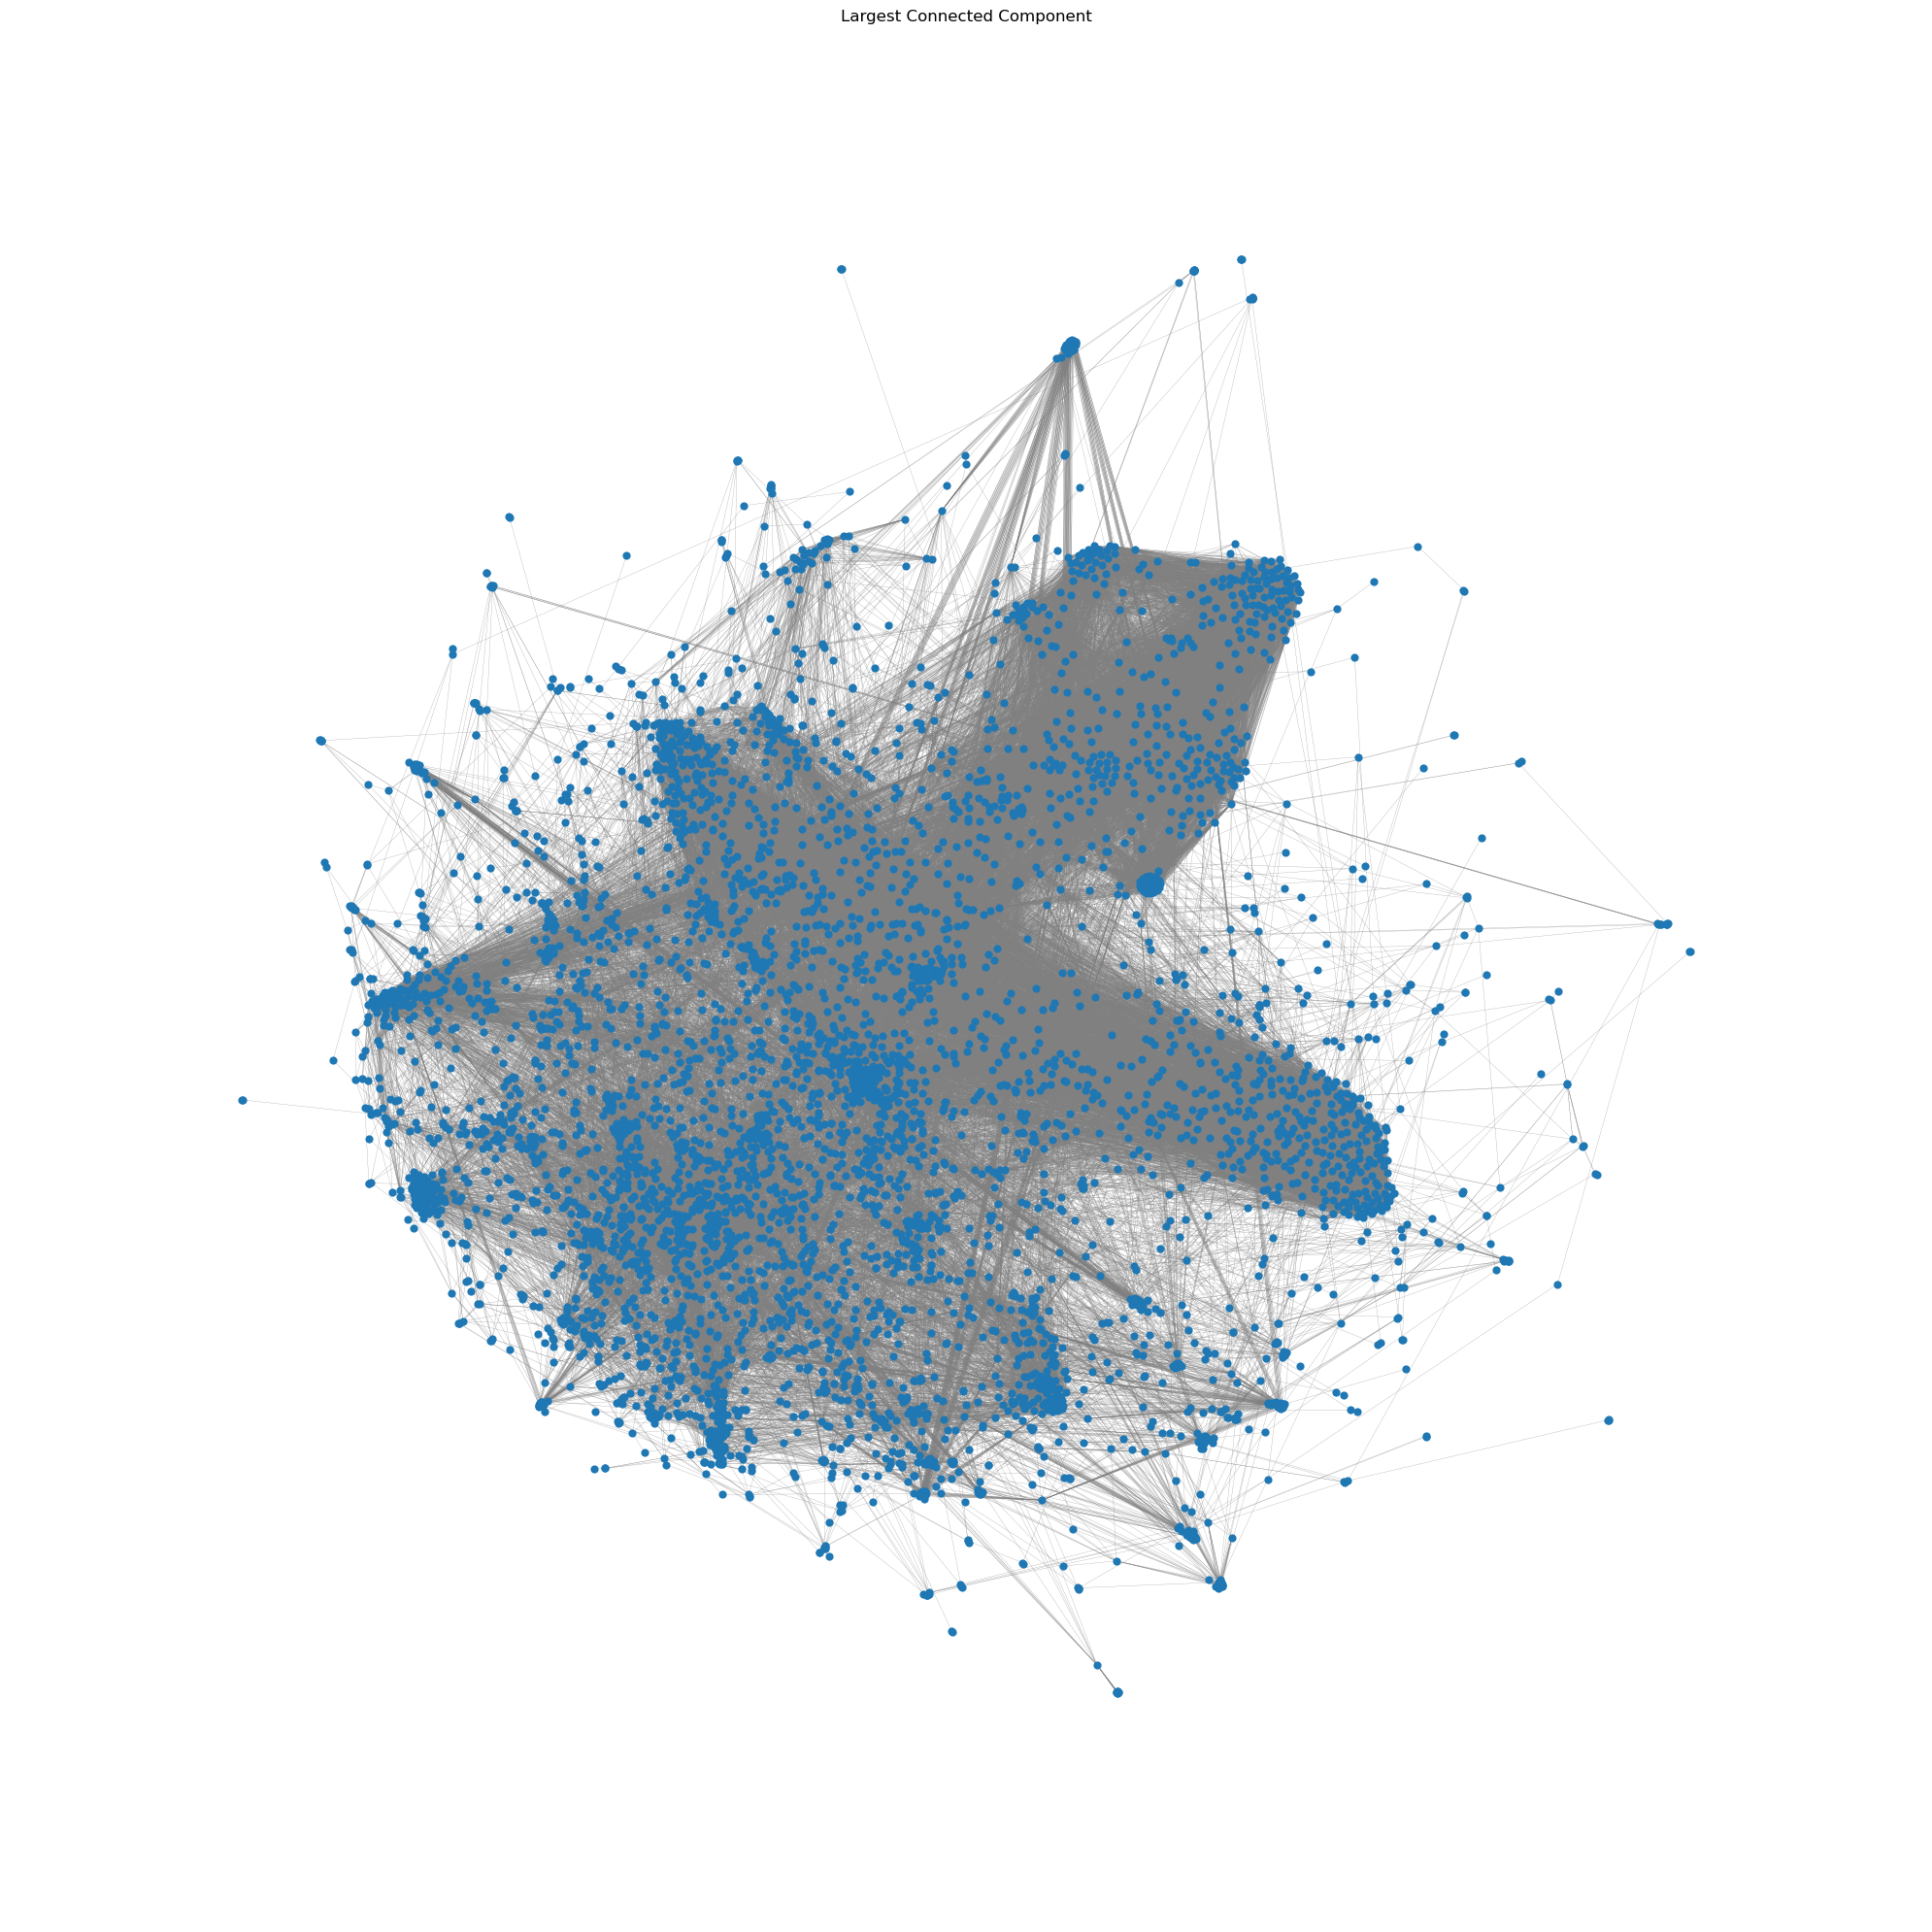

In [21]:
fig, ax = plt.subplots(1,1, figsize=(20, 20))

nx.draw_networkx_nodes(G, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('All Components')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(20, 20))

nx.draw_networkx_nodes(H, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(H, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('Largest Connected Component')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Degree Distribution')

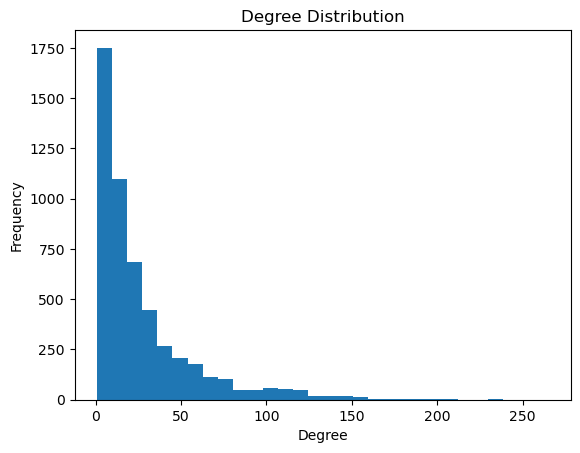

In [19]:
degrees = [H.degree(n) for n in H.nodes()]

plt.hist(degrees, bins=30)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')

In [20]:
country_counts = Counter([G.nodes[node]["country"][0] for node in G.nodes])
df = pd.DataFrame(list(country_counts.items()), columns=["country", "count"])

fig = px.choropleth(
    df,
    locations="country",          # Column with country names
    locationmode="country names", # Let Plotly match names automatically
    color="count",                # Color scale based on article count
    color_continuous_scale="Viridis",
    title="Number of Articles per Country",
)

fig.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_41644\1180037039.py:4: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(
